In [586]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image
import shutil
import pandas as pd
import cv2
from IPython.display import clear_output
import os
from sklearn import preprocessing
import matplotlib.patches as patches
import time

# Create Dataset

In [587]:
Haak1_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_true_annot.csv')
Haak1_anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_ano_object_annot.csv')
Haak1_anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_ano_land_annot.csv')

Haak3_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')
Haak3_anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_object_annot.csv')
Haak3_anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_land_annot.csv')

Danilo_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_true_annot.csv')
Danilo_anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_ano_land_annot.csv')
Empty_df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Empty.csv')

In [588]:
# Haak - Flight 1
Haak1_true_train       = Haak1_true_df.sample(frac = 0.7, random_state = 100)
Haak1_true_test        = Haak1_true_df.drop(Haak1_true_train.index)

Haak1_ano_object_train = Haak1_anomalies_object_df.sample(frac = 0.7, random_state = 100)
Haak1_ano_object_test  = Haak1_anomalies_object_df.drop(Haak1_ano_object_train.index)

Haak1_ano_land_train   = Haak1_anomalies_land_df.sample(frac = 0.7, random_state = 100)
Haak1_ano_land_test    = Haak1_anomalies_land_df.drop(Haak1_ano_land_train.index)
 
# Haak - Flight 1
Haak3_true_test        = Haak3_true_df
Haak3_ano_object_test  = Haak3_anomalies_object_df
Haak3_ano_land_test    = Haak3_anomalies_land_df

# Danilo
Danilo_true_test       = Danilo_true_df
Danilo_ano_land_test   = Danilo_anomalies_land_df
empty                  = Empty_df

# Evaluation Helper-functions

In [9]:
def covering_rectangle_from_square_boxes(boxes):
    output = np.array([])
    
    if len(boxes):
        x_left = np.min(boxes[:,0])
        width = np.max(boxes[:,0] + boxes[:,2] - x_left)
        y_top = np.min(boxes[:,1])
        height = np.max(boxes[:,1] + boxes[:,3] - y_top)
        
        output = np.array([[x_left, y_top, width, height]])

    return output

def intersection_info(box_i, box_j):
    # NMS
    x_left_i, y_upper_i, w_i, h_i = box_i
    x_right_i = x_left_i + w_i
    y_lower_i = y_upper_i + h_i
    area_i = w_i*h_i

    x_left_j, y_upper_j, w_j, h_j = box_j
    x_right_j = x_left_j + w_j
    y_lower_j = y_upper_j + h_j
    area_j = w_j*h_j

    x_left  = max(x_left_i, x_left_j)
    y_upper = max(y_upper_i, y_upper_j)

    x_right = min(x_right_i, x_right_j)
    y_lower = min(y_lower_i, y_lower_j)

    w_intersec = max(0, x_right - x_left)
    h_intersec = max(0, y_lower - y_upper)

    intersection_area = w_intersec*h_intersec
    union_area = area_i + area_j - intersection_area
    IoU = intersection_area / union_area
    
    return list([x_left, y_upper, w_intersec, h_intersec, intersection_area, union_area, IoU, area_i, area_j])

def compare_predictions_with_truth(pred_boxes, true_boxes):
    
    intersection_boxes = []
    match_found_pred = np.ones(len(pred_boxes))
    match_found_true = np.ones(len(true_boxes))
    
    for i, box_pred in enumerate(pred_boxes):
        for j, box_true in enumerate(true_boxes):
                     
            x_left, y_upper, w_intsc, h_intsc, A_intsc, A_union, IoU, A_pred, A_true  = intersection_info(box_pred, box_true)
            
            if IoU >= 0.1:
                match_found_pred[i] = 0
                match_found_true[j] = 0
                intersection_boxes = [*intersection_boxes, [x_left, y_upper, w_intsc, h_intsc]]
            
            elif (IoU >= 0.05) and ((A_intsc>=A_pred) or (A_intsc>=A_true)):
                match_found_pred[i] = 0
                match_found_true[j] = 0
                intersection_boxes = [*intersection_boxes, [x_left, y_upper, w_intsc, h_intsc]]
            
            
    intersection_boxes = np.array(intersection_boxes)
        
    false_positives = match_found_pred.sum()
    false_negatives = match_found_true.sum()
    true_positives  = len(match_found_true) - false_negatives
                
    return intersection_boxes, false_positives, false_negatives, true_positives

def boxes_from_mask(mask, area_threshold):
    
    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 2)
    
    # Threshold by area
    contours_areathrsh = []
    for cnt in contours:
        if cv2.contourArea(cnt) > area_threshold:
            contours_areathrsh = [*contours_areathrsh, cnt]
    contours_areathrsh = np.array(contours_areathrsh)
    
    # combine boxes thresholded
    boxes = []
    for i, cnt in enumerate(contours_areathrsh):
        box = cv2.boundingRect(cnt)
        boxes = [*boxes, box]
    boxes = np.array(boxes)

    return boxes

def plot_results(img, mask, pred_boxes, true_boxes, intersection_boxes, title):
    colors = ['r', 'c', 'g', 'b', 'y', 'm']
    
    clear_output(wait=True)
    fig = plt.figure(figsize=(21,10))

    # Plot boxes - Area thresholded
    plt.subplot(1,2,1)
    plt.imshow(mask, cmap='gray')
    ax = plt.gca()
    
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax = plt.gca()

    for i, box in enumerate(intersection_boxes):
        x,y,w,h = box # upper left
        rect = patches.Rectangle((x,y), w,h, edgecolor='y', facecolor='y', fill=True, linewidth=2, alpha=0.25)
        ax.add_patch(rect)     
    
    for i, box in enumerate(pred_boxes):
        x,y,w,h = box # upper left
        rect = patches.Rectangle((x,y), w,h, edgecolor='r', fill=False, linewidth=2)
        ax.add_patch(rect)
        
    for i, box in enumerate(true_boxes):
        x,y,w,h = box # upper left
        rect = patches.Rectangle((x,y), w,h, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(rect)           
        
     
    fig.suptitle(title + ' | Found: {}, Truth: {}'.format(len(pred_boxes), len(true_boxes)), fontsize=18)
    plt.show()

In [42]:
def run_edge_detection(threshold_mask, gaussian_mask, img_dir, true_df, object_df, land_df):
    
    #####################################################
    area_threshold = 9
    
    testObjects = True
    testLand = True
    testTrue = True
    
    doPlots = True
    #####################################################

    files = os.listdir(img_dir)
    n_files = len(files)

    loops = n_files

    object_metrics = {'FPs':0, 'FNs':0, 'TPs': 0}
    land_metrics   = {'FPs':0, 'FNs':0, 'TPs': 0}
    true_metrics   = {'FPs':0, 'FNs':0, 'TPs': 0}

    scenery = ''

    for i, file in enumerate(files[:loops]):
        true_boxes = []
        pred_boxes = []
        intersection_boxes = []
        FP, FN, TP = 0,0,0

        if i>0:

            img = np.array(Image.open(os.path.join(img_dir, file)))

            isAnomObject = object_df['file'].str.contains(file).sum()
            isAnomLand   = land_df['file'].str.contains(file).sum()
            isTrue       = true_df['file'].str.contains(file).sum()

            ##################### ALGORITHM #####################
            mask = edge_detection(img, threshold_mask, gaussian_mask)
            #####################################################

            if isAnomObject and testObjects:
                scenery = 'Object'
                true_boxes = object_df[object_df['file'] == file]
                true_boxes = true_boxes[['x','y','w','h']].to_numpy()      
            elif isAnomLand and testLand:
                scenery = 'Land'
                true_boxes = land_df[land_df['file'] == file]
                true_boxes = true_boxes[['x','y','w','h']].to_numpy()       
            elif isTrue and testTrue:
                scenery = 'Nothing'
            else:
                scenery = 'Error'
                continue

            # Pred Boxes
            pred_boxes = boxes_from_mask(mask, area_threshold)

            if isAnomLand:
                pred_boxes = covering_rectangle_from_square_boxes(pred_boxes) # Combine small boxes

            # Calculate accuracy
            intersection_boxes, FP, FN, TP = compare_predictions_with_truth(pred_boxes, true_boxes)

            # Metrics
            if isAnomObject and testObjects: 
                update = {'FPs':FP, 'FNs':FN, 'TPs': TP}
                object_metrics = {i: object_metrics.get(i, 0) + update.get(i, 0) for i in set(update)}
            elif isAnomLand and testLand:
                update = {'FPs':FP, 'FNs':FN, 'TPs': TP}
                land_metrics = {i: land_metrics.get(i, 0) + update.get(i, 0) for i in set(update)}
            elif isTrue and testTrue:
                update = {'FPs':FP, 'FNs':FN, 'TPs': TP}
                true_metrics = {i: true_metrics.get(i, 0) + update.get(i, 0) for i in set(update)}

            # Plot
            title = 'FP: {}, FN: {}, TP: {} | {}'.format(FP, FN, TP, scenery)

            if doPlots:
                plot_results(img, mask, pred_boxes, true_boxes, intersection_boxes, title)
                
            print('{}/{}'.format(int(file.split('.')[0]), n_files), end='\r')
            
    print('\n\n######## mask threshold: {} | gaussian threshold: {} ########'.format(threshold_mask, gaussian_mask))    
    print('Object: {}'.format(object_metrics))
    print('Recall: {:.4f}'.format(object_metrics['TPs']/(object_metrics['FNs']+object_metrics['TPs']+0.00000001)))
    print('Precision: {:.4f}'.format(object_metrics['TPs']/(object_metrics['FPs']+object_metrics['TPs']+0.00000001)))
    print('--------')
    print('Land: {}'.format(land_metrics))
    print('Recall: {:.4f}'.format(land_metrics['TPs']/(land_metrics['FNs']+land_metrics['TPs']+0.00000001)))
    print('Precision: {:.4f}'.format(land_metrics['TPs']/(land_metrics['FPs']+land_metrics['TPs']+0.00000001)))
    print('--------')
    print('True: {}'.format(true_metrics))
    print('Recall: {:.4f}'.format(true_metrics['TPs']/(true_metrics['FNs']+true_metrics['TPs']+0.00000001)))
    print('Precision: {:.4f}'.format(true_metrics['TPs']/(true_metrics['FPs']+true_metrics['TPs']+0.00000001)))

### Haak - Flight 1 - Train / Validate

# Average Bounding Box

In [43]:
Haak1_img_dir = '/Volumes/Samsung_T5/Haak_data/Flight1/20170926_norm_1100-3900/'
Haak3_img_dir = '/Volumes/Samsung_T5/Haak_data/Flight3/20170926_norm_1100-3900/'

object_df = Haak3_anomalies_object_df
img_dir = Haak3_img_dir

files = os.listdir(img_dir)
n_files = len(files)

loops = n_files

scenery = ''
    
for i, file in enumerate(files[:loops]):
        true_boxes = []
        pred_boxes = []
        intersection_boxes = []
        FP, FN, TP = 0,0,0

        if i>0:
            print(file)

            img = np.array(Image.open(os.path.join(img_dir, file)))

            isAnomObject = object_df['file'].str.contains(file).sum()
            #isAnomLand   = land_df['file'].str.contains(file).sum()
            #isTrue       = true_df['file'].str.contains(file).sum()
            
            if isAnomObject:
                scenery = 'Object'
                true_boxes = object_df[object_df['file'] == file]
                true_boxes = true_boxes[['x','y','w','h']].to_numpy()
                print([list(true_boxes[0])])
                
                b = [list(np.array(true_boxes[0], dtype=np.uint8))]
                
                contours, hierarchy = cv2.findContours(b.copy(), cv2.RETR_EXTERNAL, 2)
                #a = cv2.contourArea(b.copy())
                print(a)
                

00002.png
[[156, 84, 24, 24]]


TypeError: Expected Ptr<cv::UMat> for argument '%s'

In [ ]:
Haak1_img_dir = '/Volumes/Samsung_T5/Haak_data/Flight1/20170926_norm_1100-3900/'
Haak3_img_dir = '/Volumes/Samsung_T5/Haak_data/Flight3/20170926_norm_1100-3900/'

object_df = Haak3_anomalies_object_df
img_dir = Haak3_img_dir

files = os.listdir(img_dir)
n_files = len(files)

loops = n_files

scenery = ''
    
for i, file in enumerate(files[:loops]):
        true_boxes = []
        pred_boxes = []
        intersection_boxes = []
        FP, FN, TP = 0,0,0

        if i>0:
            print(file)

            img = np.array(Image.open(os.path.join(img_dir, file)))

            isAnomObject = object_df['file'].str.contains(file).sum()
            #isAnomLand   = land_df['file'].str.contains(file).sum()
            #isTrue       = true_df['file'].str.contains(file).sum()
            
            if isAnomObject:
                scenery = 'Object'
                true_boxes = object_df[object_df['file'] == file]
                true_boxes = true_boxes[['x','y','w','h']].to_numpy()
                print([list(true_boxes[0])])
                
                b = [list(np.array(true_boxes[0], dtype=np.uint8))]
                
                contours, hierarchy = cv2.findContours(b.copy(), cv2.RETR_EXTERNAL, 2)
                #a = cv2.contourArea(b.copy())
                print(a)
                

# DISTRIBUTION .PPM

In [114]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image
import shutil
import pandas as pd

In [28]:
'''
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/' # 14-bit

true_imgs = []
ano_object_imgs = []
ano_land_imgs = []

files = len(os.listdir(directory))
loops = files
loops = files
j = 0

for i, file in enumerate(os.listdir(directory)[:loops]):
    print(str(i) + '/' + str(files), end='\r')

    file_png = file.split('.')[0][1:] + '.png'
    #isAnomObject = anomalies_object_df['Anomalies_object'].str.contains(file_png).sum()
    #isAnomLand   = anomalies_land_df['Anomalies_land'].str.contains(file_png).sum()
    #isTrue       = anomalies_true_df['True'].str.contains(file_png).sum()
    isTrue       = anomalies_true_df['file'].str.contains(file_png).sum() # For Haak 1
    
    if isTrue:
        j = j + 1
        if j % 100 == 0:
            img = np.array(Image.open(os.path.join(directory, file)))
            true_imgs = [*true_imgs, img]
    
    '''
    if isAnomObject:
        img = np.array(Image.open(os.path.join(directory, file)))
        ano_object_imgs = [*ano_object_imgs, img]
        
    if isAnomLand:
        img = np.array(Image.open(os.path.join(directory, file)))
        ano_land_imgs = [*ano_land_imgs, img]
    '''
    
        
true_imgs       = np.array(true_imgs)
ano_object_imgs = np.array(ano_object_imgs)
ano_land_imgs   = np.array(ano_land_imgs)
'''

## Flight 1

In [122]:
#anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_object.csv')
#anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_land.csv')
#anomalies_all_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_all.csv')
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/' # 14-bit

true_imgs = []
ano_object_imgs = []
ano_land_imgs = []
files = len(anomalies_true_df)

minim = 100000
maxim = 0


j = 0

for i, file in anomalies_true_df.iterrows():
    print(str(i) + '/' + str(files), end='\r')

    file_ppm = str(file[0]).split('.')[0][:] + '.ppm'
    
    #if np.array(Image.open(os.path.join(directory, file_ppm))).min() < minim:
    #    minim = np.array(Image.open(os.path.join(directory, file_ppm))).min()
        
    #if np.array(Image.open(os.path.join(directory, file_ppm))).max() > maxim:
    #    maxim = np.array(Image.open(os.path.join(directory, file_ppm))).max()

    j = j + 1
    if j % 4 == 0:
        img = np.array(Image.open(os.path.join(directory, file_ppm)))
        true_imgs = [*true_imgs, img]

    '''
    if isAnomObject:
        img = np.array(Image.open(os.path.join(directory, file)))
        ano_object_imgs = [*ano_object_imgs, img]
        
    if isAnomLand:
        img = np.array(Image.open(os.path.join(directory, file)))
        ano_land_imgs = [*ano_land_imgs, img]
    '''
    
        
true_imgs       = np.array(true_imgs)
ano_object_imgs = np.array(ano_object_imgs)
ano_land_imgs   = np.array(ano_land_imgs)

In [120]:
true_imgs_F1_flat = true_imgs.flatten()
true_imgs = []

In [121]:
true_imgs_F1_flat.max()
true_imgs_F1_flat.min()

2064

In [124]:
# FOR ALL DATA, NOT 25%
minimF1 = minim
maximF1 = maxim
print(minimF1)
print(maximF1)

2061
2716


### MEAN and STD - Only Ocean

In [143]:
#anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_object.csv')
#anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_land.csv')
#anomalies_all_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_all.csv')
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/' # 14-bit

files = len(anomalies_true_df)
S1 = 0
S2 = 0

j = 0

for i, file in anomalies_true_df.iterrows():
    j = j+1
    print(str(i) + '/' + str(files), end='\r')
    
    file_ppm = str(file[0]).split('.')[0][:] + '.ppm'
    
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    S1 = S1 + img.sum();
    S2 = S2 + (np.square(img)).sum()


n = files*(512*640);
meanF1 = S1 / n
stdF1 = np.sqrt((S2/n) - np.square(S1/n))

print(meanF1)
print(stdF1)

2298.6581469940597
52.74587678319086


In [146]:
stdF1

52.74587678319086

In [112]:
(np.square(img)).sum()

1944344340259

### MAX MIN / MEAN MEDIAN

In [242]:
#anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_object.csv')
#anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_land.csv')
#anomalies_all_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_all.csv')
anomalies_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/' # 14-bit

files = len(anomalies_df)

min_list = []
max_list = []

for i, file in anomalies_df.iterrows():
    print(str(i) + '/' + str(files), end='\r')
    
    #file_ppm = str(file[1]).split('.')[0] + '.ppm'
    file_ppm = str(file[0]).split('.')[0] + '.ppm'
    
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    max_list = [*max_list, img.max()]
    min_list = [*min_list, img.min()]
    
print(np.mean(max_list))
print(np.median(max_list))
print(np.mean(min_list))
print(np.median(min_list))

print(np.max(max_list))
print(np.min(min_list))

2429.947053751078
2386.0
2177.535441218741
2178.0
2716
2061


## Flight 3

In [151]:
#anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_object.csv')
#anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_land.csv')
#anomalies_all_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_all.csv')
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/' # 14-bit

true_imgs = []
ano_object_imgs = []
ano_land_imgs = []
files = len(anomalies_true_df)

minim = 100000
maxim = 0


j = 0

for i, file in anomalies_true_df.iterrows():
    print(str(i) + '/' + str(files), end='\r')

    file_ppm = str(file[0]).split('.')[0][:] + '.ppm'
    
    #if np.array(Image.open(os.path.join(directory, file_ppm))).min() < minim:
    #    minim = np.array(Image.open(os.path.join(directory, file_ppm))).min()
        
    #if np.array(Image.open(os.path.join(directory, file_ppm))).max() > maxim:
    #    maxim = np.array(Image.open(os.path.join(directory, file_ppm))).max()
    
    j = j + 1
    if j % 4 == 0:
        img = np.array(Image.open(os.path.join(directory, file_ppm)))
        true_imgs = [*true_imgs, img]

    '''
    if isAnomObject:
        img = np.array(Image.open(os.path.join(directory, file)))
        ano_object_imgs = [*ano_object_imgs, img]
        
    if isAnomLand:
        img = np.array(Image.open(os.path.join(directory, file)))
        ano_land_imgs = [*ano_land_imgs, img]
    '''
    
        
true_imgs       = np.array(true_imgs)
ano_object_imgs = np.array(ano_object_imgs)
ano_land_imgs   = np.array(ano_land_imgs)

In [152]:
true_imgs_F3_flat = true_imgs.flatten()

In [130]:
# FOR ALL DATA, NOT 25%
minimF3 = minim
maximF3 = maxim
print(minimF3)
print(maximF3)

2082
2646


### MEAN and STD - Only Ocean

In [142]:
#anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_object.csv')
#anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_land.csv')
#anomalies_all_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_all.csv')
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/' # 14-bit

files = len(anomalies_true_df)
S1 = 0
S2 = 0

j = 0

for i, file in anomalies_true_df.iterrows():
    j = j+1
    print(str(i) + '/' + str(files), end='\r')
    
    file_ppm = str(file[0]).split('.')[0] + '.ppm'
    
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    S1 = S1 + img.sum();
    S2 = S2 + (np.square(img)).sum()


n = files*(512*640);
meanF3 = S1 / n
stdF3 = np.sqrt((S2/n) - np.square(S1/n))

print(meanF3)
print(stdF3)

2322.7988361340495
65.77939364196439


### MAX MIN / MEAN MEDIAN

In [235]:
#anomalies_object_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_object.csv')
#anomalies_land_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_land.csv')
#anomalies_all_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Anomalies_all.csv')
anomalies_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/' # 14-bit

files = len(anomalies_df)

min_list = []
max_list = []

for i, file in anomalies_df.iterrows():
    print(str(i) + '/' + str(files), end='\r')
    
    #file_ppm = str(file[1]).split('.')[0] + '.ppm'
    file_ppm = str(file[0]).split('.')[0] + '.ppm'
    
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    max_list = [*max_list, img.max()]
    min_list = [*min_list, img.min()]
    
print(np.mean(max_list))
print(np.median(max_list))
print(np.mean(min_list))
print(np.median(min_list))

2775437
2775
2093
2093


In [224]:
str(file[1]).split('.')[0]

'00001'

In [12]:
n_files

20712

In [13]:
n/(512*640)

20712.0

In [49]:
######### FULL RANGE
# F3
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

n = 0

S1 = 0
S2 = 0
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')

    file_ppm = file
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    S1 = S1 + img.sum();
    S2 = S2 + (np.square(img)).sum()
    
    n = n + 1

n = n*(512*640);
meanF3 = S1 / n
stdF3 = np.sqrt((S2/n) - np.square(S1/n))

print(meanF3)
print(stdF3)

2336.243854566868
82.94994282396902


In [11]:
######### FULL RANGE
# F1
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

n = 0

S1 = 0
S2 = 0
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')

    file_ppm = file
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    S1 = S1 + img.sum();
    S2 = S2 + (np.square(img)).sum()
    
    n = n + 1

n = n*(512*640);
meanF1 = S1 / n
stdF1 = np.sqrt((S2/n) - np.square(S1/n))

print(meanF1)
print(stdF1)

2304.671866375749
63.47013344439207


In [51]:
######### FULL RANGE
# DANILO
directory = '/Volumes/Samsung_T5/Danilo_data_All/IR/All-Frames-Simple/'
files = os.listdir(directory)
n_files = len(files)

n = 0
S1 = 0
S2 = 0
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')

    file_png = file
    img = np.array(Image.open(os.path.join(directory, file_png)))
    
    S1 = S1 + img.sum();
    S2 = S2 + (np.square(img)).sum()
    
    n = n + 1

n = n*(480*640);
meanDAN = S1 / n_files
stdDAN = np.sqrt( (S2/n_files) - np.square(S1/n_files) )

print(meanDAN)
print(stdDAN)

98.9289480722664
nan


<ipython-input-51-70bf1d5bf70d>:23: RuntimeWarning: invalid value encountered in sqrt
  stdDAN = np.sqrt((S2/n) - np.square(S1/n))


# Full Range Plot DAN

In [67]:
######### FULL RANGE
# F1
directory = '/Volumes/Samsung_T5/Danilo_data_All/IR/All-Frames-Simple/'
files = os.listdir(directory)
n_files = len(files)

full_rangeDAN = []
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    img = np.array(Image.open(os.path.join(directory, file)))
    full_rangeDAN = [*full_rangeDAN, img]
full_rangeDAN = np.array(full_rangeDAN).flatten()

In [78]:
250/3

83.33333333333333

In [68]:
np.percentile(full_rangeDAN,[1,99])

array([ 25., 173.])

In [ ]:
figure(figsize=(15, 3))

fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)
n, bins, patches = plt.hist(full_rangeDAN, 85, density=True, edgecolor='None'
                            , facecolor='g', alpha=0.50, label='Flight 3')
plt.vlines(x=[25,173], ymin=0, ymax=0.017, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

#plt.xlim((1100,3900))
plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F3.pdf', bbox_inches='tight')
plt.show()

In [65]:
#df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_true_annot.csv')
df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_ano_land_annot.csv')

directory = '/Volumes/Samsung_T5/Danilo_data_All/IR/All-Frames-Simple/' # 8-bit

files = len(df)

min_list = []
max_list = []

for i, file in df.iterrows():
    print(str(i) + '/' + str(files), end='\r')
    
    file_png = str(file[1]).split('.')[0] + '.png'
    #file_png = str(file[0]).split('.')[0] + '.png'
    
    img = np.array(Image.open(os.path.join(directory, file_png)))
    
    max_list = [*max_list, img.max()]
    min_list = [*min_list, img.min()]
    
print(np.mean(max_list))
print(np.median(max_list))
print(np.mean(min_list))
print(np.median(min_list))

215.72549019607843
208.0
0.12254901960784313
0.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)

#fig, ax = figure(figsize=(15, 3))

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

x = np.arange(0, 360, 1)
y = np.sin(2 * x * np.pi / 180)

ax.hist(full_rangeF1, 200, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
ax.hist(full_rangeF3, 200, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 2')
n, bins, patches = plt.hist(full_rangeDAN, 85, density=True, edgecolor='None'
                            , facecolor='g', alpha=0.50, label='Flight 3')

#plt.xlim((1125,3925))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
#plt.vlines(x=[1153,3895], ymin=0, ymax=0.008, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')


plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)


def deg2rad(x):
    return 256*(x - 1100) /(3900-1100)


def rad2deg(x):
    return x

secax = ax.secondary_xaxis(-0.4, functions=(deg2rad, rad2deg))
secax.set_xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
secax.xaxis.set_tick_params(labelsize=24)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPM1100-3900.pdf', bbox_inches='tight')

plt.show()

# Full Range Plot HAAK

In [ ]:
######### FULL RANGE
# F1
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

full_rangeF1 = []
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    file_ppm = file
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    full_rangeF1 = [*full_rangeF1, img]
full_rangeF1 = np.array(full_rangeF1).flatten()

######### FULL RANGE
# F3
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

full_rangeF3 = []
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    file_ppm = file
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    full_rangeF3 = np.append(full_rangeF3, img)
full_rangeF3 = np.array(full_rangeF3).flatten()

In [18]:
######### ONLY SURFACE
# F1
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_true_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/' # 14-bit

full_rangeF1_true = []
n_files = len(anomalies_true_df)

for i, file in anomalies_true_df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file_ppm = str(file[0]).split('.')[0][:] + '.ppm'
    #if i % 4 == 0:
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    full_rangeF1_true = [*full_rangeF1_true, img]
        
full_rangeF1_true = np.array(full_rangeF1_true).flatten()

# F3
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/' # 14-bit

full_rangeF3_true = []
n_files = len(anomalies_true_df)

for i, file in anomalies_true_df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file_ppm = str(file[0]).split('.')[0][:] + '.ppm'
    #if i % 4 == 0:
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    full_rangeF3_true = [*full_rangeF3_true, img]
        
full_rangeF3_true = np.array(full_rangeF3_true).flatten()

In [ ]:
figure(figsize=(15, 3))

fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)
n, bins, patches = plt.hist(full_rangeF1, 300, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
n, bins, patches = plt.hist(full_rangeF3, 300, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 2')
plt.vlines(x=[1153,3895], ymin=0, ymax=0.008, colors='purple', ls='--', lw=2.5, label='Min/Max')

plt.xlim((0,16383))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPMfullrange.pdf', bbox_inches='tight')
plt.show()

In [21]:
full_range_F1F2 = np.append(full_rangeF1, full_rangeF3)

In [27]:
np.percentile(full_range_F1F2,[1,99])

array([2175., 2547.])

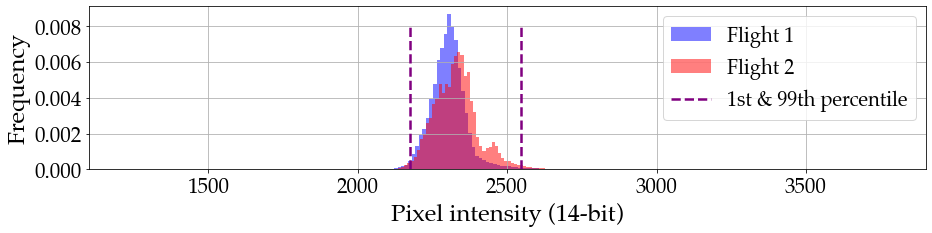

In [37]:
figure(figsize=(15, 3))

fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)
n, bins, patches = plt.hist(full_rangeF1, 200, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
n, bins, patches = plt.hist(full_rangeF3, 200, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 2')
plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='purple', ls='--', lw=2.5, label='1st & 99th percentile')

plt.xlim((1100,3900))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPM1100-3900.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)

#fig, ax = figure(figsize=(15, 3))

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

x = np.arange(0, 360, 1)
y = np.sin(2 * x * np.pi / 180)

ax.hist(full_rangeF1, 200, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
ax.hist(full_rangeF3, 200, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 2')

plt.xlim((1125,3925))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
plt.vlines(x=[1153,3895], ymin=0, ymax=0.008, colors='purple', ls='--', lw=2.5, label='Min/Max')
plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)


def deg2rad(x):
    return 256*(x - 1100) /(3900-1100)


def rad2deg(x):
    return x

secax = ax.secondary_xaxis(-0.4, functions=(deg2rad, rad2deg))
secax.set_xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
secax.xaxis.set_tick_params(labelsize=24)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPM1100-3900.pdf', bbox_inches='tight')

plt.show()

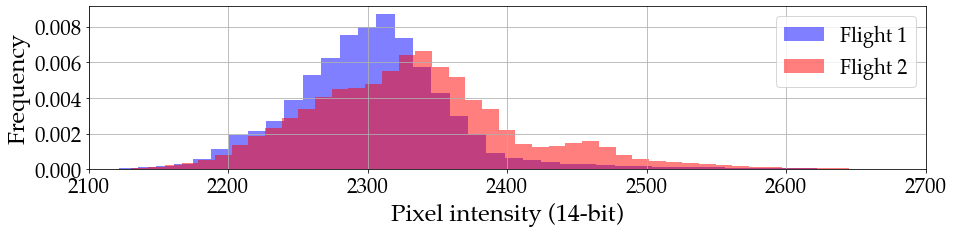

In [248]:
figure(figsize=(15, 3))

fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)
n, bins, patches = plt.hist(full_rangeF1, 200, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
n, bins, patches = plt.hist(full_rangeF3, 200, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 2')


plt.xlim((2100,2700))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPMzoomed.pdf', bbox_inches='tight')
plt.show()

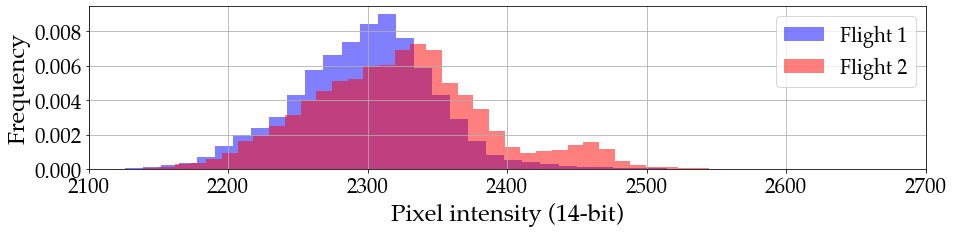

In [249]:
figure(figsize=(15, 3))

fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)
n, bins, patches = plt.hist(full_rangeF1_true, 50, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
n, bins, patches = plt.hist(full_rangeF3_true, 50, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 2')


plt.xlim((2100,2700))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPMtrue.pdf', bbox_inches='tight')
plt.show()

# HAAK On Top Of Each - MEDIAN PLOT

<Figure size 432x288 with 0 Axes>

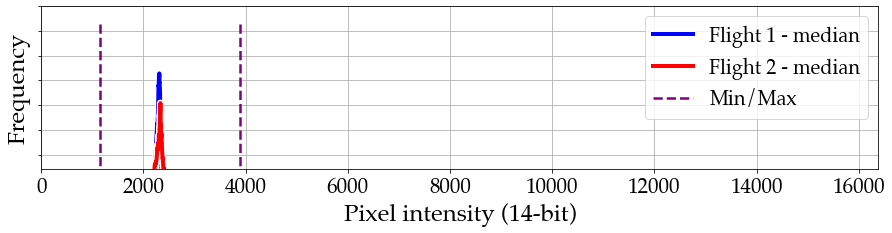

In [163]:
######### FULL RANGE
# F3
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

min_all = 1333
max_all = 3751

min_all = 2000
max_all = 2750


#plt.hlines(y=0, xmin=1500, xmax=1501, colors='blue', ls='-', lw=2.5, label='Flight 1')
plt.plot(edges[:-1], np.median(histF1,0), color='blue', ls='-', linewidth=4, alpha=1, label='Flight 1 - median',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

plt.plot(edges[:-1], np.median(histF3,0), color='r', ls='-', linewidth=4, alpha=1, label='Flight 2 - median',
        path_effects=[pe.Stroke(linewidth=7, foreground='white'), pe.Normal()])



###########################################################################################
plt.xlim((0,16383))
plt.ylim((0.001,0.0175))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)


plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_PPMfullrange.pdf', bbox_inches='tight')
plt.show()

# ALL DISTRIBUTION F1 F2 ----- USED IN REPORT

4443/20712

7442/20712

12940/20712

15939/20712

1225/6893

<Figure size 432x288 with 0 Axes>

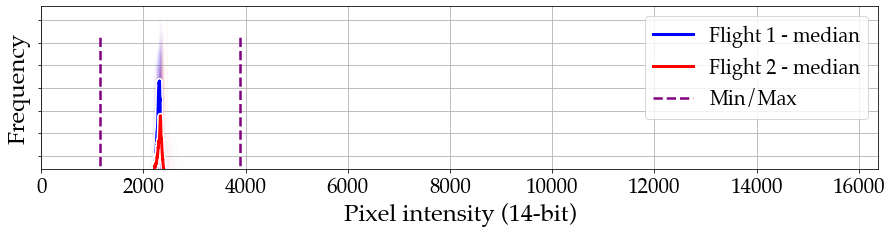

In [280]:
######### FULL RANGE
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

min_all = 1333
max_all = 3751

min_all = 2000
max_all = 3000

#histF1 = []
#edgesF1 = []

# F1
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    if i%414==0:
        img = np.array(Image.open(os.path.join(directory, file)))
        #hist, edges = np.histogram(img.flatten(), 
        #                       density=True, 
        #                       bins=(max_all-min_all)+1, 
        #                       range=(min_all,max_all+1) )
        hist, edges = np.histogram(img.flatten(), 
                       density=True, 
                       bins=(max_all-min_all),
                       range=(min_all,max_all) )
        #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
        #                    , facecolor='b', alpha=0.1)
        plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
        #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
        ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)


###########################################################################################
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

min_all = 1333
max_all = 3751

min_all = 2000
max_all = 3000

#histF3 = []
#edgesF3 = []

# F1
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    if i%138==0:
        img = np.array(Image.open(os.path.join(directory, file)))
        #hist, edges = np.histogram(img.flatten(), 
        #                       density=True, 
        #                       bins=(max_all-min_all)+1, 
        #                       range=(min_all,max_all+1) )
        hist, edges = np.histogram(img.flatten(), 
                       density=True, 
                       bins=(max_all-min_all), 
                       range=(min_all,max_all) )
        #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
        #                    , facecolor='b', alpha=0.1)
        plt.plot(edges[:-1], hist, color='r', linewidth=2, alpha=0.002)
        #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
        ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='r', alpha=0.002)


#plt.hlines(y=0, xmin=1500, xmax=1501, colors='blue', ls='-', lw=2.5, label='Flight 1')
#plt.plot(edges[:-1], np.median(histF1,0), color='white', ls='-', linewidth=3, alpha=1)
plt.plot(edges[:-1], np.median(histF1,0), color='blue', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])


#plt.hlines(y=0, xmin=1500, xmax=1501, colors='blue', ls='-', lw=2.5, label='Flight 1')
plt.plot(edges[:-1], np.median(histF3,0), color='r', ls='-', linewidth=3, alpha=1, label='Flight 2 - median',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

###########################################################################################
plt.xlim((0,16383))
plt.ylim((0.001,0.019))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1_PPM1100-3900.pdf', bbox_inches='tight')

plt.show()

<Figure size 432x288 with 0 Axes>

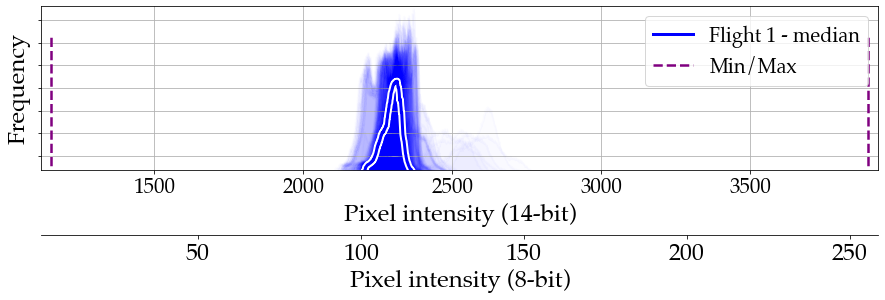

In [351]:
######### FULL RANGE
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
import numpy as np
from scipy.integrate import simps
from numpy import trapz
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

min_all = 1333
max_all = 3751

min_all = 2000
max_all = 3000

histF1 = []
edgesF1 = []

# F1
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    if i%83==0:
        img = np.array(Image.open(os.path.join(directory, file)))
        #hist, edges = np.histogram(img.flatten(), 
        #                       density=True, 
        #                       bins=(max_all-min_all)+1, 
        #                       range=(min_all,max_all+1) )
        hist, edges = np.histogram(img.flatten(), 
                       density=True, 
                       bins=(max_all-min_all),
                       range=(min_all,max_all) )
        #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
        #                    , facecolor='b', alpha=0.1)
        plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.01)
        #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
        ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.01)

        histF1 = [*histF1, hist]

histF1 = np.array(histF1)
edgesF1 = np.array(edges)

#plt.hlines(y=0, xmin=1500, xmax=1501, colors='blue', ls='-', lw=2.5, label='Flight 1')
#plt.plot(edges[:-1], np.median(histF1,0), color='white', ls='-', linewidth=3, alpha=1)
plt.plot(edges[:-1], np.median(histF1,0), color='blue', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
        path_effects=[pe.Stroke(linewidth=7, foreground='white'), pe.Normal()])

###########################################################################################
plt.xlim((1120,3930))
plt.ylim((0.001,0.019))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

def deg2rad(x):
    return 256*(x - 1100) /(3900-1100)


def rad2deg(x):
    return x

secax = ax.secondary_xaxis(-0.4, functions=(deg2rad, rad2deg))
secax.set_xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
secax.xaxis.set_tick_params(labelsize=24)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1_PPM1100-3900.pdf', bbox_inches='tight')

plt.show()

<Figure size 432x288 with 0 Axes>

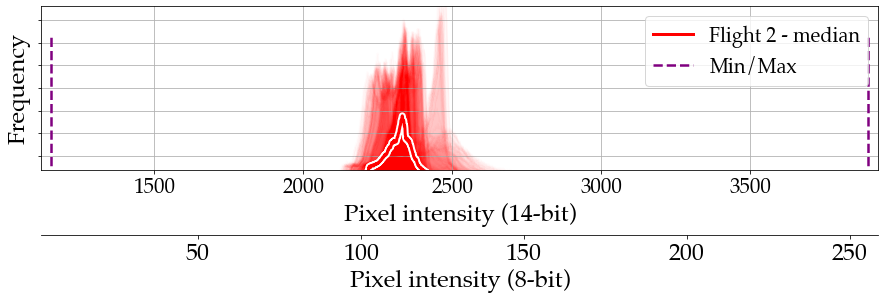

In [354]:
######### FULL RANGE
# F3
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/'
files = os.listdir(directory)
n_files = len(files)

min_all = 1333
max_all = 3751

min_all = 2000
max_all = 3000

histF3 = []
edgesF3 = []

# F1
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    if i%28==0:
        img = np.array(Image.open(os.path.join(directory, file)))
        #hist, edges = np.histogram(img.flatten(), 
        #                       density=True, 
        #                       bins=(max_all-min_all)+1, 
        #                       range=(min_all,max_all+1) )
        hist, edges = np.histogram(img.flatten(), 
                       density=True, 
                       bins=(max_all-min_all), 
                       range=(min_all,max_all) )
        #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
        #                    , facecolor='b', alpha=0.1)
        plt.plot(edges[:-1], hist, color='r', linewidth=2, alpha=0.01)
        #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
        ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='r', alpha=0.01)

        histF3 = [*histF3, hist]

histF3 = np.array(histF3)
edgesF3 = np.array(edges)

#plt.hlines(y=0, xmin=1500, xmax=1501, colors='blue', ls='-', lw=2.5, label='Flight 1')
plt.plot(edges[:-1], np.median(histF3,0), color='r', ls='-', linewidth=3, alpha=1, label='Flight 2 - median',
        path_effects=[pe.Stroke(linewidth=7, foreground='white'), pe.Normal()])


###########################################################################################
plt.xlim((1120,3930))
plt.ylim((0.001,0.019))
plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)


def deg2rad(x):
    return 256*(x - 1100) /(3900-1100)


def rad2deg(x):
    return x

secax = ax.secondary_xaxis(-0.4, functions=(deg2rad, rad2deg))
secax.set_xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
secax.xaxis.set_tick_params(labelsize=24)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F2_PPM1100-3900.pdf', bbox_inches='tight')
plt.show()

# DANILO DATA - MEDIAN ----- USED IN REPORT

<Figure size 432x288 with 0 Axes>

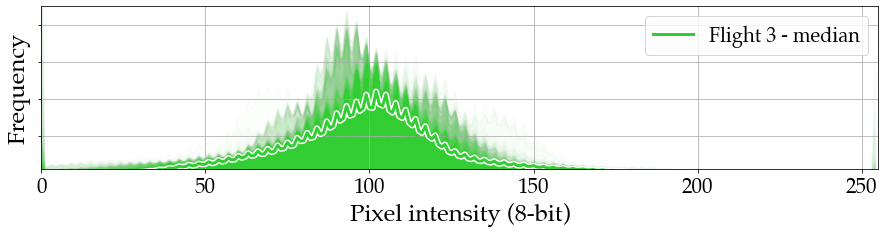

In [353]:
######### FULL RANGE
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
directory = '/Volumes/Samsung_T5/Danilo_data_All/IR/All-Frames-Simple/'
files = os.listdir(directory)
n_files = len(files)

min_all = 0
max_all = 255

histDAN = []
edgesDAN = []

# F1
for i, file in enumerate(files):
    print(str(i) + '/' + str(n_files), end='\r')
    if i%3==0:
        img = np.array(Image.open(os.path.join(directory, file)))
        hist, edges = np.histogram(img.flatten(), 
                               density=True, 
                               bins=255,
                               range=(0,255) )
        
        #n, bins, patches = plt.hist(img.flatten(), bins=100, density=True, edgecolor='None'
        #                    , facecolor='g', alpha=0.1)
        plt.plot(edges[:-1], hist, color='limegreen', linewidth=2, alpha=0.01)
        #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
        ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='limegreen', alpha=0.01)

        
        hist, edges = np.histogram(img.flatten(), 
                       density=True, 
                       bins=255,
                       range=(0,255) )

        histDAN = [*histDAN, hist]

histDAN = np.array(histDAN)
edgesDAN = np.array(edges)

#from scipy.interpolate import make_interp_spline, BSpline
#import matplotlib.pyplot as plt 
#X_Y_Spline = make_interp_spline(edges[:-1], np.median(histDAN,0), k=25)
#Y = X_Y_Spline(edges[:-1])

#plt.hlines(y=0, xmin=1500, xmax=1501, colors='blue', ls='-', lw=2.5, label='Flight 1')
#plt.plot(edges[:-1], np.median(histF1,0), color='white', ls='-', linewidth=3, alpha=1)
plt.plot(edges[:-1], np.median(histDAN,0), color='limegreen', ls='-', linewidth=3, alpha=1, label='Flight 3 - median',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

###########################################################################################
plt.xlim((0,255))
plt.ylim((0.001,0.045))
plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')
#plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[2175,2547], ymin=0, ymax=0.008, colors='teal', ls='--', lw=2.5, label='1st & 99th percentile')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F3_dist.pdf', bbox_inches='tight')
plt.show()

## ALL Three ------- USED IN REPORT

### Normal scene

<Figure size 432x288 with 0 Axes>

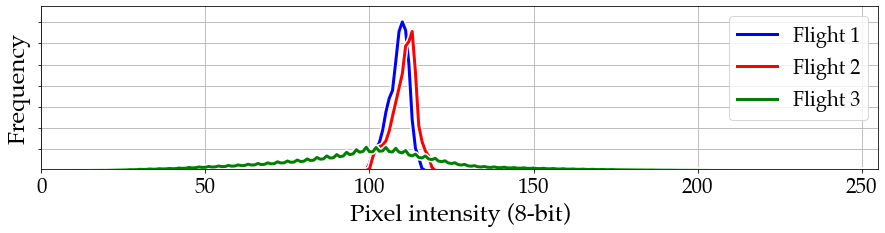

In [342]:
######### FULL RANGE
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
import numpy as np
from scipy.integrate import simps
from numpy import trapz
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
min_all = 0
max_all = 255

histF1 = []
edgesF1 = []

# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_true_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[0]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))
    #hist, edges = np.histogram(img.flatten(), 
    #                       density=True, 
    #                       bins=(max_all-min_all)+1, 
    #                       range=(min_all,max_all+1) )
    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=(max_all-min_all),
                   range=(min_all,max_all) )
    #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
    #                    , facecolor='b', alpha=0.1)
    #plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
    #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
    #ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)
    histF1 = [*histF1, hist]

histF1 = np.array(histF1)
edgesF1 = np.array(edges)


###########################################################################################
min_all = 0
max_all = 255

histF3 = []
edgesF3 = []

# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[0]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))
    #hist, edges = np.histogram(img.flatten(), 
    #                       density=True, 
    #                       bins=(max_all-min_all)+1, 
    #                       range=(min_all,max_all+1) )
    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=(max_all-min_all),
                   range=(min_all,max_all) )
    #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
    #                    , facecolor='b', alpha=0.1)
    #plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
    #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
    #ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)
    histF3 = [*histF3, hist]

histF3 = np.array(histF3)
edgesF3 = np.array(edges)

###########################################################################################

df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_true_annot.csv')
directory = '/Volumes/Samsung_T5/Danilo_data/IR/All-Frames-Simple/' # 8-bit
n_files = len(df)

files = os.listdir(directory)
n_files = len(files)

min_all = 0
max_all = 255

histDAN = []
edgesDAN = []

# F1
for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[0]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))

    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=255,
                   range=(0,255) )

    histDAN = [*histDAN, hist]

histDAN = np.array(histDAN)
edgesDAN = np.array(edges)

###########################################################################################

yF1 = np.median(histF1,0)
area = trapz(yF1,x=edgesF1[:-1], dx=1)
normF1 = yF1/area

yF3 = np.median(histF3,0)
area = trapz(yF3,x=edgesF3[:-1], dx=1)
normF3 = yF3/area

yDAN = np.median(histDAN,0)
area = trapz(yDAN,x=edgesDAN[:-1], dx=1)
normDAN = yDAN/area


#plt.plot(edges[:-1], yF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesF1[:-1], normF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#plt.plot(edges[:-1], yF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesF3[:-1], normF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 2',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#plt.plot(edges[:-1], yDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesDAN[:-1], normDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 3',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])



plt.xlim((0,255))
plt.ylim((0.001,0.155))
plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2F3_PNG_median_NORMAL.pdf', bbox_inches='tight')

plt.show()

# AnoGAN - Scores

In [589]:
Haak1_obj_loss = np.load(r'/Volumes/Samsung_T5/AnoGAN_Eval/Haak1_obj_loss.npy')

Haak1_land_loss = np.load(r'/Volumes/Samsung_T5/AnoGAN_Eval/Haak1_land_loss.npy')

Haak1_true_loss = np.load(r'/Volumes/Samsung_T5/AnoGAN_Eval/Haak1_true_loss.npy')

In [613]:
!pip3 install seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 280.9 kB/s eta 0:00:00a 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

<Figure size 432x288 with 0 Axes>

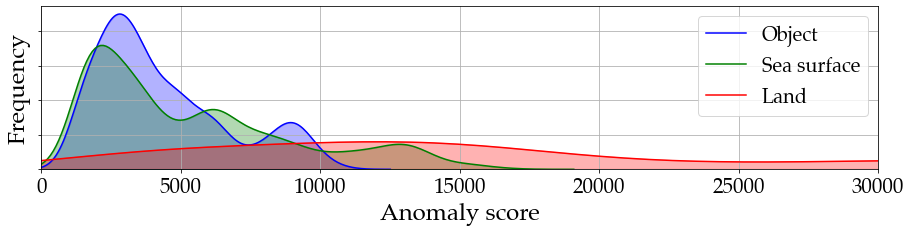

In [634]:
######### FULL RANGE
# F1
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
import numpy as np
from scipy.integrate import simps
from numpy import trapz
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################


#plt.hist(Haak1_obj_loss, density=True, label='Object', alpha=0.5, bins=20, color='b')
#plt.hist(Haak1_true_loss, density=True, label='Sea surface', alpha=0.5, bins=20, color='r')
#plt.hist(Haak1_land_loss, density=True, label='Land', alpha=0.5, bins=100, color='g')

#plt.plot(edges[:-1], yF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
#plt.plot(edges_obj[:-1], hist_obj, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1',
        #path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
                                   
#ax.fill_between(edges_obj[:-1], 0, hist_obj, interpolate=True, color='limegreen', alpha=0.01)

#plt.plot(edges[:-1], yF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
#plt.plot(edges_land[:-1], hist_land, color='r', ls='-', linewidth=3, alpha=1, label='Flight 2',
        #path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
                                   
#ax.fill_between(edges_land[:-1], 0, hist_land, interpolate=True, color='limegreen', alpha=0.01)

#plt.plot(edges[:-1], yDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
#plt.plot(edges_true[:-1], hist_true, color='g', ls='-', linewidth=3, alpha=1, label='Flight 3',
        #path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#ax.fill_between(edges_true[:-1], 0, hist_true, interpolate=True, color='limegreen', alpha=0.01)

sns.distplot(Haak1_obj_loss,label='Object', color='b', norm_hist=True, hist=False)
sns.distplot(Haak1_true_loss,label='Sea surface', color='g', norm_hist=True, hist=False)
sns.distplot(Haak1_land_loss,label='Land', color='r', norm_hist=True, hist=False)

#plt.xlim((0,20000))
#plt.ylim((0.001,0.155))
plt.xlabel('Anomaly score', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 30000)

#plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2F3_PNG_median_NORMAL.pdf', bbox_inches='tight')

l1 = ax.lines[0]
l2 = ax.lines[1]
l3 = ax.lines[2]
# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]

ax.fill_between(x1,y1, color="b", alpha=0.3)
ax.fill_between(x2,y2, color="g", alpha=0.3)
ax.fill_between(x3,y3, color="r", alpha=0.3)


plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/Anomaly_score.pdf', bbox_inches='tight')

plt.show()

### Boat scene

<Figure size 432x288 with 0 Axes>

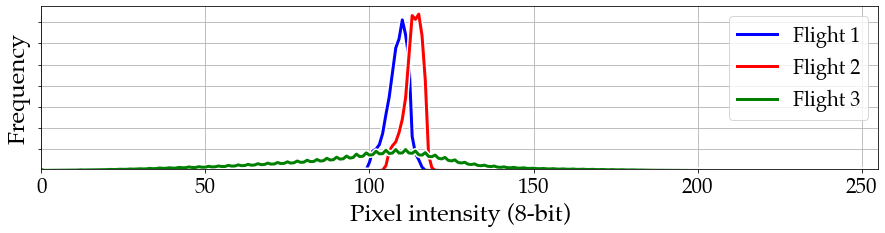

In [341]:
######### 
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
import numpy as np
from scipy.integrate import simps
from numpy import trapz
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
min_all = 0
max_all = 255

histF1 = []
edgesF1 = []

# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_ano_object_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[1]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))
    #hist, edges = np.histogram(img.flatten(), 
    #                       density=True, 
    #                       bins=(max_all-min_all)+1, 
    #                       range=(min_all,max_all+1) )
    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=(max_all-min_all),
                   range=(min_all,max_all) )
    #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
    #                    , facecolor='b', alpha=0.1)
    #plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
    #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
    #ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)
    histF1 = [*histF1, hist]

histF1 = np.array(histF1)
edgesF1 = np.array(edges)


###########################################################################################
min_all = 0
max_all = 255

histF3 = []
edgesF3 = []

# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_object_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[1]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))
    #hist, edges = np.histogram(img.flatten(), 
    #                       density=True, 
    #                       bins=(max_all-min_all)+1, 
    #                       range=(min_all,max_all+1) )
    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=(max_all-min_all),
                   range=(min_all,max_all) )
    #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
    #                    , facecolor='b', alpha=0.1)
    #plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
    #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
    #ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)
    histF3 = [*histF3, hist]

histF3 = np.array(histF3)
edgesF3 = np.array(edges)

###########################################################################################

df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Danilo_data/IR/All-Frames-Simple/' # 8-bit
n_files = len(df)

files = os.listdir(directory)
n_files = len(files)

min_all = 0
max_all = 255

histDAN = []
edgesDAN = []

# F1
for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[1]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))

    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=255,
                   range=(0,255) )

    histDAN = [*histDAN, hist]

histDAN = np.array(histDAN)
edgesDAN = np.array(edges)

###########################################################################################

yF1 = np.median(histF1,0)
area = trapz(yF1,x=edgesF1[:-1], dx=1)
normF1 = yF1/area

yF3 = np.median(histF3,0)
area = trapz(yF3,x=edgesF3[:-1], dx=1)
normF3 = yF3/area

yDAN = np.median(histDAN,0)
area = trapz(yDAN,x=edgesDAN[:-1], dx=1)
normDAN = yDAN/area


#plt.plot(edges[:-1], yF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesF1[:-1], normF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#plt.plot(edges[:-1], yF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesF3[:-1], normF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 2',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#plt.plot(edges[:-1], yDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesDAN[:-1], normDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 3',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])



plt.xlim((0,255))
plt.ylim((0.001,0.155))
plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2F3_PNG_median_OBJECT.pdf', bbox_inches='tight')

plt.show()

### Land scene

<Figure size 432x288 with 0 Axes>

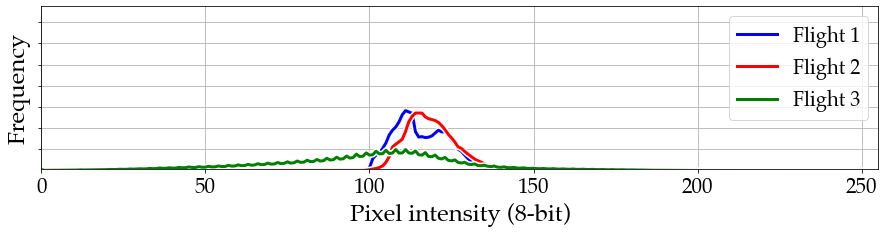

In [585]:
######### 
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
import numpy as np
from scipy.integrate import simps
from numpy import trapz
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################
min_all = 0
max_all = 255

histF1 = []
edgesF1 = []

# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[1]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))
    #hist, edges = np.histogram(img.flatten(), 
    #                       density=True, 
    #                       bins=(max_all-min_all)+1, 
    #                       range=(min_all,max_all+1) )
    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=(max_all-min_all),
                   range=(min_all,max_all) )
    #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
    #                    , facecolor='b', alpha=0.1)
    #plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
    #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
    #ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)
    histF1 = [*histF1, hist]

histF1 = np.array(histF1)
edgesF1 = np.array(edges)


###########################################################################################
min_all = 0
max_all = 255

histF3 = []
edgesF3 = []

# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[1]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))
    #hist, edges = np.histogram(img.flatten(), 
    #                       density=True, 
    #                       bins=(max_all-min_all)+1, 
    #                       range=(min_all,max_all+1) )
    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=(max_all-min_all),
                   range=(min_all,max_all) )
    #n, bins, patches = plt.hist(img.flatten(), bins=50, density=True, edgecolor='None'
    #                    , facecolor='b', alpha=0.1)
    #plt.plot(edges[:-1], hist, color='b', linewidth=2, alpha=0.002)
    #plt.bar(edges[:-1], hist, color='b', linewidth=2.5, alpha=0.02)
    #ax.fill_between(edges[:-1], 0, hist, interpolate=True, color='b', alpha=0.002)
    histF3 = [*histF3, hist]

histF3 = np.array(histF3)
edgesF3 = np.array(edges)

###########################################################################################

df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Danilo_data/IR/All-Frames-Simple/' # 8-bit
n_files = len(df)

files = os.listdir(directory)
n_files = len(files)

min_all = 0
max_all = 255

histDAN = []
edgesDAN = []

# F1
for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file = str(file[1]).split('.')[0][:] + '.png'

    img = np.array(Image.open(os.path.join(directory, file)))

    hist, edges = np.histogram(img.flatten(), 
                   density=True, 
                   bins=255,
                   range=(0,255) )

    histDAN = [*histDAN, hist]

histDAN = np.array(histDAN)
edgesDAN = np.array(edges)

###########################################################################################

yF1 = np.median(histF1,0)
area = trapz(yF1,x=edgesF1[:-1], dx=1)
normF1 = yF1/area

yF3 = np.median(histF3,0)
area = trapz(yF3,x=edgesF3[:-1], dx=1)
normF3 = yF3/area

yDAN = np.median(histDAN,0)
area = trapz(yDAN,x=edgesDAN[:-1], dx=1)
normDAN = yDAN/area


#plt.plot(edges[:-1], yF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesF1[:-1], normF1, color='b', ls='-', linewidth=3, alpha=1, label='Flight 1',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#plt.plot(edges[:-1], yF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesF3[:-1], normF3, color='r', ls='-', linewidth=3, alpha=1, label='Flight 2',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])

#plt.plot(edges[:-1], yDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 1 - median',
#        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])
plt.plot(edgesDAN[:-1], normDAN, color='g', ls='-', linewidth=3, alpha=1, label='Flight 3',
        path_effects=[pe.Stroke(linewidth=6, foreground='white'), pe.Normal()])



plt.xlim((0,255))
plt.ylim((0.001,0.155))
plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2F3_PNG_median_LAND.pdf', bbox_inches='tight')

plt.show()

# Avg object area

In [422]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image
import shutil
import pandas as pd
import cv2
from IPython.display import clear_output
import os
from sklearn import preprocessing
import matplotlib.patches as patches
import time

In [461]:
###########################################################################################
# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_ano_object_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

w_list_obj = []
h_list_obj = []
a_list_obj = []

for i, file in df.iterrows():
    #print(str(i) + '/' + str(n_files), end='\r')

    w_list_obj = [*w_list_obj, file['w']]
    h_list_obj = [*h_list_obj, file['h']]
    a_list_obj = [*a_list_obj, file['w']*file['h']]


w_list_obj = np.array(w_list_obj)
h_list_obj = np.array(h_list_obj)
a_list_obj = np.array(a_list_obj)

print(100*np.mean((w_list_obj * h_list_obj) / (512*640)))
print(100*np.mean(a_list_obj) / (512*640))

print(100*np.median((w_list_obj * h_list_obj) / (512*640)))
print(100*np.median(a_list_obj) / (512*640))

###########################################################################################
# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight1/Haak1_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight1/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

w_list_land = []
h_list_land = []
a_list_land = []

for i, file in df.iterrows():
    #print(str(i) + '/' + str(n_files), end='\r')

    w_list_land = [*w_list_land, file['w']]
    h_list_land = [*h_list_land, file['h']]
    a_list_land = [*a_list_land, file['w']*file['h']]


w_list_land = np.array(w_list_land)
h_list_land = np.array(h_list_land)
a_list_land = np.array(a_list_land)

print(100*np.mean((w_list_land * h_list_land) / (512*640)))
print(100*np.mean(a_list_land) / (512*640))

print(100*np.median((w_list_land * h_list_land) / (512*640)))
print(100*np.median(a_list_land) / (512*640))

0.21705832338257802
0.21705832338257802
0.20339965820312503
0.203399658203125
62.160751890993396
62.1607518909934
67.5
67.5


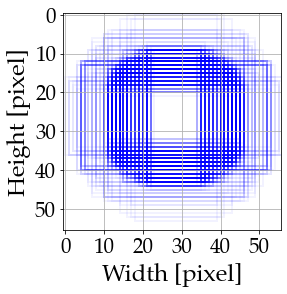

In [466]:
fig, ax = plt.subplots(figsize=(15, 4))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

img = np.ones((np.max([*w_list_obj, *h_list_obj]), np.max([*w_list_obj, *h_list_obj])))

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
ax = plt.gca()

center_w = int(np.max(w_list_obj)/2)
center_h = int(np.max(h_list_obj)/2)
#center_w = int(640/2)
#center_h = int(512/2)

for i, (w, h) in enumerate(zip(w_list_obj,h_list_obj)):
    if i%2 == 0:
        x = center_w-int(w/2)
        y = center_h-int(h/2)
        rect = patches.Rectangle((x,y), w,h, edgecolor='b', fill=False, linewidth=2, alpha=0.05)
        ax.add_patch(rect)

#plt.xlim((0,255))
#plt.ylim((0.001,0.155))
plt.xlabel('Width [pixel]', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Height [pixel]', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

#plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1_label_size_obj.pdf', bbox_inches='tight')

plt.show()

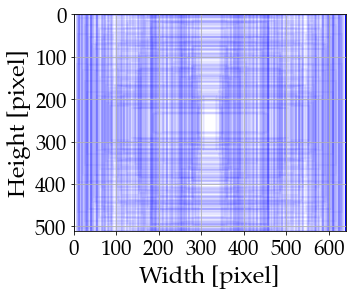

In [467]:
fig, ax = plt.subplots(figsize=(15, 4))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

img = np.ones((512,640))

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
ax = plt.gca()

center_w = int(640/2)
center_h = int(512/2)
#center_w = int(640/2)
#center_h = int(512/2)

for i, (w, h) in enumerate(zip(w_list_land,h_list_land)):
    if i%2 == 0:
        x = center_w-int(w/2)
        y = center_h-int(h/2)
        rect = patches.Rectangle((x,y), w,h, edgecolor='b', fill=False, linewidth=2, alpha=0.05)
        ax.add_patch(rect)

#plt.xlim((0,255))
#plt.ylim((0.001,0.155))
plt.xlabel('Width [pixel]', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Height [pixel]', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

#plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1_label_size_land.pdf', bbox_inches='tight')

plt.show()

In [494]:
###########################################################################################
# F3
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_object_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

w_list_obj = []
h_list_obj = []
a_list_obj = []

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')

    w_list_obj = [*w_list_obj, file['w']]
    h_list_obj = [*h_list_obj, file['h']]
    a_list_obj = [*a_list_obj, file['w']*file['h']]


w_list_obj = np.array(w_list_obj)
h_list_obj = np.array(h_list_obj)
a_list_obj = np.array(a_list_obj)

print(100*np.mean((w_list_obj * h_list_obj) / (512*640)))
print(100*np.mean(a_list_obj) / (512*640))

print(100*np.median((w_list_obj * h_list_obj) / (512*640)))
print(100*np.median(a_list_obj) / (512*640))

###########################################################################################
# F3
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
n_files = len(df)

w_list_land = []
h_list_land = []
a_list_land = []

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')

    w_list_land = [*w_list_land, file['w']]
    h_list_land = [*h_list_land, file['h']]
    a_list_land = [*a_list_land, file['w']*file['h']]


w_list_land = np.array(w_list_land)
h_list_land = np.array(h_list_land)
a_list_land = np.array(a_list_land)

print(100*np.mean((w_list_land * h_list_land) / (512*640)))
print(100*np.mean(a_list_land) / (512*640))

print(100*np.median((w_list_land * h_list_land) / (512*640)))
print(100*np.median(a_list_land) / (512*640))

0.09501651440932495
0.09501651440932493
0.091552734375
0.091552734375


73.52052351695606
73.52052351695605
100.0
100.0


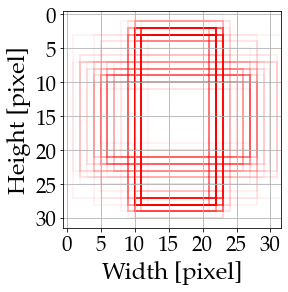

In [495]:
fig, ax = plt.subplots(figsize=(15, 4))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

img = np.ones((np.max([*w_list_obj, *h_list_obj]), np.max([*w_list_obj, *h_list_obj])))

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
ax = plt.gca()

center_w = int(np.max(w_list_obj)/2)
center_h = int(np.max(h_list_obj)/2)
#center_w = int(640/2)
#center_h = int(512/2)

for i, (w, h) in enumerate(zip(w_list_obj,h_list_obj)):
    if i%2 == 0:
        x = center_w-int(w/2)
        y = center_h-int(h/2)
        rect = patches.Rectangle((x,y), w,h, edgecolor='r', fill=False, linewidth=2, alpha=0.05)
        ax.add_patch(rect)

#plt.xlim((0,255))
#plt.ylim((0.001,0.155))
plt.xlabel('Width [pixel]', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Height [pixel]', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

#plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F2_label_size_obj.pdf', bbox_inches='tight')

plt.show()

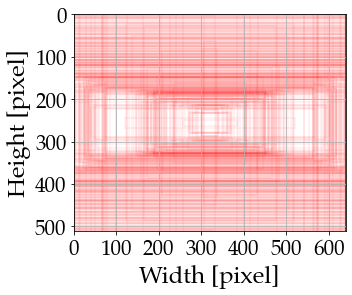

In [496]:
fig, ax = plt.subplots(figsize=(15, 4))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

img = np.ones((512,640))

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
ax = plt.gca()

center_w = int(640/2)
center_h = int(512/2)
#center_w = int(640/2)
#center_h = int(512/2)

for i, (w, h) in enumerate(zip(w_list_land,h_list_land)):
    if i%2 == 0:
        x = center_w-int(w/2)
        y = center_h-int(h/2)
        rect = patches.Rectangle((x,y), w,h, edgecolor='r', fill=False, linewidth=2, alpha=0.05)
        ax.add_patch(rect)

#plt.xlim((0,255))
#plt.ylim((0.001,0.155))
plt.xlabel('Width [pixel]', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Height [pixel]', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

#plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F2_label_size_land.pdf', bbox_inches='tight')

plt.show()

In [492]:
###########################################################################################
# F1
df = pd.read_csv(r'/Volumes/Samsung_T5/Danilo_data/IR/Danilo_ano_land_annot.csv')
n_files = len(df)

w_list_obj = []
h_list_obj = []
a_list_obj = []

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')

    w_list_obj = [*w_list_obj, file['w']]
    h_list_obj = [*h_list_obj, file['h']]
    a_list_obj = [*a_list_obj, file['w']*file['h']]


w_list_obj = np.array(w_list_obj)
h_list_obj = np.array(h_list_obj)
a_list_obj = np.array(a_list_obj)

print(100*np.mean((w_list_obj * h_list_obj) / (512*640)))
print(100*np.mean(a_list_obj) / (512*640))

print(100*np.median((w_list_obj * h_list_obj) / (512*640)))
print(100*np.median(a_list_obj) / (512*640))

37.37148658902037
37.37148658902037
36.331787109375
36.331787109375


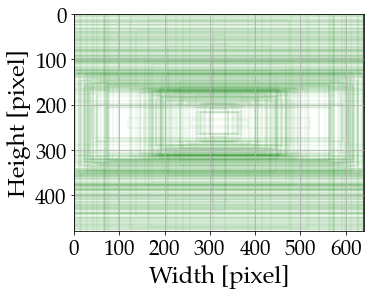

In [493]:
fig, ax = plt.subplots(figsize=(15, 4))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

img = np.ones((480,640))

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
ax = plt.gca()

center_w = int(np.max(w_list_obj)/2)
center_h = int(np.max(h_list_obj)/2)
#center_w = int(640/2)
#center_h = int(512/2)

for i, (w, h) in enumerate(zip(w_list_land,h_list_land)):
    if i%2 == 0:
        x = center_w-int(w/2)
        y = center_h-int(h/2)
        rect = patches.Rectangle((x,y), w,h, edgecolor='green', fill=False, linewidth=2, alpha=0.05)
        ax.add_patch(rect)

#plt.xlim((0,255))
#plt.ylim((0.001,0.155))
plt.xlabel('Width [pixel]', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Height [pixel]', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

#plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F3_label_size_anomaly.pdf', bbox_inches='tight')

plt.show()

In [485]:
np.max(w_list_obj)

640

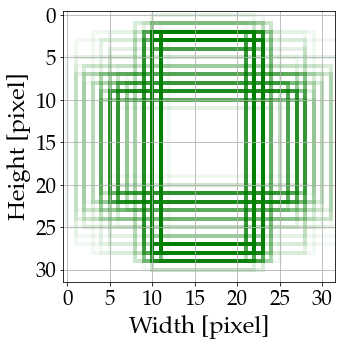

In [412]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image
import shutil
import pandas as pd
import cv2
from IPython.display import clear_output
import os
from sklearn import preprocessing
import matplotlib.patches as patches
import time

fig, ax = plt.subplots(figsize=(15, 5))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

img = np.ones((np.max([*w_list_obj, *h_list_obj]), np.max([*w_list_obj, *h_list_obj])))

plt.imshow(img, cmap='gray', vmin=0, vmax=1)
ax = plt.gca()

center_w = int(np.max(w_list_obj)/2)
center_h = int(np.max(h_list_obj)/2)
#center_w = int(640/2)
#center_h = int(512/2)

for i, (w, h) in enumerate(zip(w_list_obj,h_list_obj)):
    x = center_w-int(w/2)
    y = center_h-int(h/2)
    rect = patches.Rectangle((x,y), w,h, edgecolor='g', fill=False, linewidth=4, alpha=0.05)
    ax.add_patch(rect)

#plt.xlim((0,255))
#plt.ylim((0.001,0.155))
plt.xlabel('Width [pixel]', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Height [pixel]', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])

#plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2F3_PNG_median_LAND.pdf', bbox_inches='tight')

plt.show()

# Show No Value In Histogram Inspection

<Figure size 432x288 with 0 Axes>

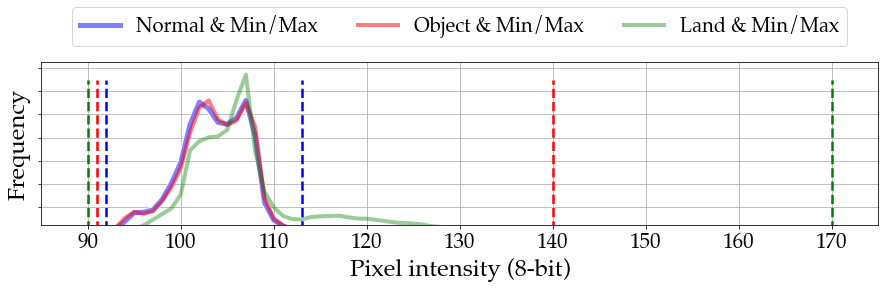

In [584]:
######### FULL RANGE
# F1
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
import matplotlib.patheffects as pe
import numpy as np
from scipy.integrate import simps
from numpy import trapz
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

fig, ax = plt.subplots(figsize=(15, 3))
fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

###########################################################################################

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit

min_all = 0
max_all = 255

file_true = '00050.png'
file_obj  = '00001.png'
file_land = '00108.png'

img_true = np.array(Image.open(os.path.join(directory, file_true)))
img_obj = np.array(Image.open(os.path.join(directory, file_obj)))
img_land = np.array(Image.open(os.path.join(directory, file_land)))

hist_true, edges = np.histogram(img_true.flatten(), density=True, bins=255, range=(0,255) )
hist_obj, edges = np.histogram(img_obj.flatten(), density=True, bins=255, range=(0,255) )
hist_land, edges = np.histogram(img_land.flatten(), density=True, bins=255, range=(0,255) )
    
###########################################################################################

area = trapz(hist_true,x=edges[:-1], dx=1)
norm_true = hist_true/area

area = trapz(hist_obj,x=edges[:-1], dx=1)
norm_obj = hist_obj/area

area = trapz(hist_land,x=edges[:-1], dx=1)
norm_land = hist_land/area


plt.plot(edges[:-1], norm_true, color='b', ls='-', linewidth=5, alpha=0.5, label='Normal & Min/Max',
        path_effects=[pe.Stroke(linewidth=7, foreground='white'), pe.Normal()])
plt.plot(edges[:-1], norm_obj, color='r', ls='-', linewidth=4, alpha=0.5, label='Object & Min/Max')
plt.plot(edges[:-1], norm_land, color='g', ls='-', linewidth=4, alpha=0.4, label='Land & Min/Max')

plt.vlines(x=[img_obj.flatten().min(),img_obj.flatten().max()], ymin=0, ymax=0.13, colors='r', ls='--', lw=2.5)
plt.vlines(x=[img_true.flatten().min(),img_true.flatten().max()], ymin=0, ymax=0.13, colors='b', ls='--', lw=2.5)
plt.vlines(x=[img_land.flatten().min(),img_land.flatten().max()], ymin=0, ymax=0.13, colors='g', ls='--', lw=2.5)

#plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')
#plt.vlines(x=[1153,3895], ymin=0, ymax=0.016, colors='purple', ls='--', lw=2.5, label='Min/Max')

plt.xlim((85,175))
plt.ylim((0.004,0.145))
plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
ax.legend(fontsize=fontsize, loc='upper center',ncol=6, prop={'size':fontsize-4, 'family': 'Palatino'}, bbox_to_anchor=(0.5,1.4))
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/norm_obj_land_density_comparison.pdf', bbox_inches='tight')

plt.show()

# FLIGHT 3 - 1100-3900

In [ ]:
anomalies_true_df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')

directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_simple-naming/' # 14-bit

files = len(anomalies_true_df)
S1 = 0
S2 = 0

j = 0

for i, file in anomalies_true_df.iterrows():
    j = j+1
    print(str(i) + '/' + str(files), end='\r')
    
    file_ppm = str(file[0]).split('.')[0] + '.ppm'
    
    img = np.array(Image.open(os.path.join(directory, file_ppm)))
    
    S1 = S1 + img.sum();
    S2 = S2 + (np.square(img)).sum()


n = files*(512*640);
meanF3 = S1 / n
stdF3 = np.sqrt((S2/n) - np.square(S1/n))

In [4]:
######### ONLY Surface
# F3
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_true_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
normalized_F3_true = []
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file_png = str(file[0]).split('.')[0][:] + '.png'
    
    img = np.array(Image.open(os.path.join(directory, file_png)))
    normalized_F3_true = [*normalized_F3_true, img]

normalized_F3_true = np.array(normalized_F3_true).flatten()

######### ONLY Object
# F3
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_object_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
normalized_F3_object = []
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file_png = str(file[1]).split('.')[0][:] + '.png'
    
    img = np.array(Image.open(os.path.join(directory, file_png)))
    normalized_F3_object = [*normalized_F3_object, img]

normalized_F3_object = np.array(normalized_F3_object).flatten()

######### ONLY Land
# F3
df = pd.read_csv(r'/Volumes/Samsung_T5/Haak_data/Flight3/Haak3_ano_land_annot.csv')
directory = '/Volumes/Samsung_T5/Haak_data_All/Flight3/20170926_norm_1100-3900/' # 8-bit
normalized_F3_land = []
n_files = len(df)

for i, file in df.iterrows():
    print(str(i) + '/' + str(n_files), end='\r')
    file_png = str(file[1]).split('.')[0][:] + '.png'
    
    img = np.array(Image.open(os.path.join(directory, file_png)))
    normalized_F3_land = [*normalized_F3_land, img]

normalized_F3_land = np.array(normalized_F3_land).flatten()

In [6]:
tes = np.append(normalized_F3_true,normalized_F3_object)
tes = np.append(tes,normalized_F3_land)

In [303]:
4*normalized_F3_object.shape[0] / (512*640)

440.0

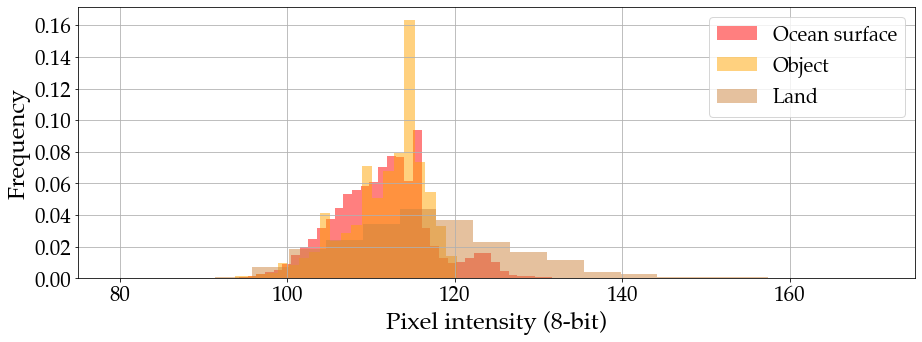

In [13]:
figure(figsize=(15, 5))

fontsize = 24
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42
plt.grid(True)

n, bins, patches = plt.hist(normalized_F3_true, 50, density=True, edgecolor='None'
                            , facecolor='red', alpha=0.50, label='Ocean surface')
n, bins, patches = plt.hist(normalized_F3_object, 50, density=True, edgecolor='None'
                            , facecolor='orange', alpha=0.50, label='Object')
n, bins, patches = plt.hist(normalized_F3_land, 50, density=True, edgecolor='None'
                            , facecolor='peru', alpha=0.50, label='Land')


plt.xlabel('Pixel intensity (8-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')

plt.legend(fontsize=fontsize, prop={'size':fontsize-4, 'family': 'Palatino'})
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(75, 175)
#plt.ylim(0, 0.03)

plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F2_dist.pdf', bbox_inches='tight')
plt.show()

In [7]:
tes.shape

(2198732800,)

## Loop Through

In [147]:
print(true_imgs_F1_flat.max())
print(true_imgs_F1_flat.min())

print(true_imgs_F3_flat.max())
print(true_imgs_F3_flat.min())

2711
2064
2646
2082


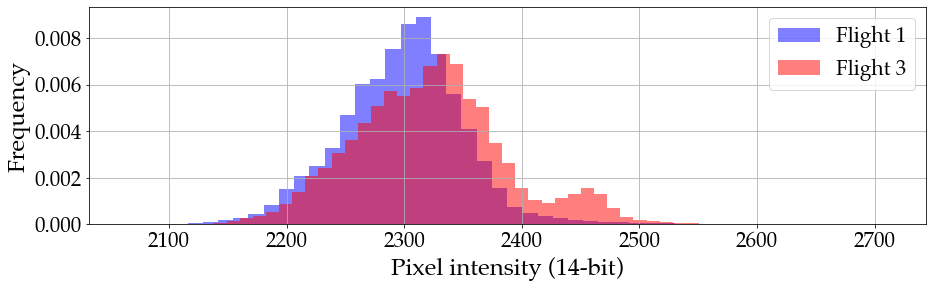

In [153]:
fontsize = 24


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
plt.rcParams['pdf.fonttype'] = 42

figure(figsize=(15, 4))
plt.grid(True)
n, bins, patches = plt.hist(true_imgs_F1_flat, 50, density=True, edgecolor='None'
                            , facecolor='b', alpha=0.50, label='Flight 1')
n, bins, patches = plt.hist(true_imgs_F3_flat, 50, density=True, edgecolor='None'
                            , facecolor='r', alpha=0.50, label='Flight 3')


plt.xlabel('Pixel intensity (14-bit)', fontsize=fontsize, fontname='Palatino')
plt.ylabel('Frequency', fontsize=fontsize, fontname='Palatino')
plt.xticks(fontsize=fontsize-3, fontname='Palatino')
plt.yticks(fontsize=fontsize-3, fontname='Palatino')


#font = font_manager.FontProperties(family='Palatino',
#                                   style='normal', size=10)

plt.legend(fontsize=fontsize, prop={'size':fontsize-3, 'family': 'Palatino'})

#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.xlim(40, 160)
#plt.ylim(0, 0.03)
plt.savefig('/Users/ola/Documents/Masteroppgave/Figures/F1F2_true_distributions.pdf', bbox_inches='tight') 
plt.show()